In [14]:
%matplotlib inline
import numpy as np
import numpy.random as rng
import pylab as pl

def sigmoid(phi):
    return 1.0/(1.0 + np.exp(-phi))

In [15]:
Npats, Nins = 100, 2
X = 5*rng.normal(1,1,size=(Npats,Nins))
w_truth = rng.normal(0,1,size=(Nins))
m_truth = rng.normal(1,1,size=(Nins))
phi = np.dot(X - m_truth, w_truth)
Targ = np.where(phi > 0.0, 1, 0)

In [16]:
def show_result():
    pl.clf()
    msize = 8
    cl ={0:'red', 1:'black'}
    for i, x in enumerate(X):
        pl.plot(x[0],x[1],'x',color=cl[int(Targ[i])],alpha=.4,markersize=msize)
        pl.plot(x[0],x[1],'o',color=cl[int(Targ[i])],alpha=1.-float(abs(Targ[i]-Y[i])),markersize=msize)
        
    pl.axis('equal')
    pl.arrow(0, 0, m[0], m[1], head_width=0.5, head_length=0.5, fc='b', ec='b', linewidth=3, alpha=.7)
    pl.arrow(m[0]-w[0], m[1]-w[1], w[0], w[1], head_width=25.0, head_length=1.0, fc='g', ec='g', linewidth=1, alpha=.35)
    pl.show()

  

## Learning, starting from random weights and bias.

### Initialise to random values so we're not 'cheating'

In [17]:
init_w = rng.normal(0,1,size=(Nins))
init_m = 4.*rng.normal(0,1,size=(Nins))
rate = 0.1 / Npats

Red and Black are target 0 and 1 patterns respectively.

They will get "filled in" once the perceptron is getting them correct.

In [18]:
def do_one_step(w,m,X,Targ,rate):
    phi = np.dot(X-m,w) 
    Y = sigmoid(phi)  # Sigmoid perceptron ('logistic regression')
    dw = (np.sum(np.atleast_2d(Targ-Y).T*(X-m), axis=0))
    dm = -(np.sum(np.atleast_2d(Targ-Y).T*w, axis=0))
    w = w + rate * dw   # one step of learning
    m = m + rate * dm   # one step of learning
    return (w,m,Y)

In [19]:
w,m,Y = do_one_step(init_w,init_m,X,Targ,0.0)
print('loss: ', np.sum(Targ*np.log(Y) + (1-Targ)*np.log(1-Y)))
print(w,m)

loss:  -364.794085326
[-0.11693328 -0.39738862] [ 3.2971443  -6.06531808]


#### Each execution of the next cell does one 'step' of learning.


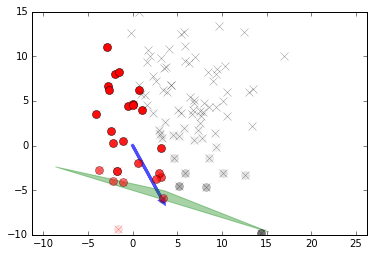

[ 0.1245754  0.4079735] [ 3.30492792 -6.03886606]
loss:  -364.794085326


In [20]:
w,m,Y = do_one_step(w,m,X,Targ,rate)
show_result()
print(w,m)
print('loss: ', np.sum(Targ*np.log(Y) + (1-Targ)*np.log(1-Y)))

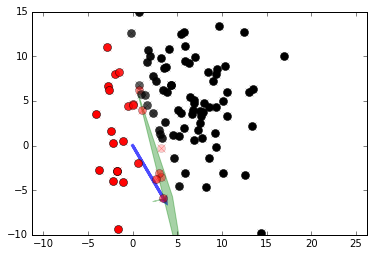

[ 1.2377507   0.30593086] [ 3.50241466 -5.97966178]
loss:  -10.6538038592


In [21]:
for t in range(100):
    w,m,Y = do_one_step(w,m,X,Targ,rate)
show_result()
print(w,m)
print('loss: ', np.sum(Targ*np.log(Y) + (1-Targ)*np.log(1-Y)))


# now trying via autograd instead...


In [30]:
import autograd.numpy as np
from autograd import grad

# Define a function that returns a loss...
def training_loss(params):
    tildex = X - params['mean']
    zvec = params['wgts']/np.sqrt(np.sum(np.power(params['wgts'],2.)))
    # zvec should be unit length: CHECK IT.
    Dr2 = np.power(np.dot(tildex, zvec), 2.0)
    L2X = (np.power(tildex, 2.0)).sum(1)
    DR2 = L2X - Dr2
    dist2 = (Dr2/params['r2']) + (DR2/params['R2'])  # rescaled 'distance' to the shifted 'origin'
    membership = np.exp(-0.5*dist2)
    membership = np.array(membership)
    #print(membership)
    #membership = 1.0 # default test, makes vanilla perceptron
    phi = np.dot(tildex, params['wgts'])
    Y = sigmoid(phi)  # Sigmoid perceptron ('logistic regression')

    #Y = sigmoid(np.dot(X-params['mean'],params['wgts'])).reshape(Npats,1)
    loss = np.sum(membership*(Targ*np.log(Y) + (1-Targ)*np.log(1-Y)))
    return loss

training_loss_gradient = grad(training_loss)

In [31]:
params = {'wgts':init_w, 'mean':init_m, 'r2':25.0, 'R2':25.0}
print("Initial params:")
for key in params.keys():
    print(key,'\t', params[key])
print("Initial loss:", training_loss(params))

Initial params:
R2 	 25.0
r2 	 25.0
wgts 	 [-0.11693328 -0.39738862]
mean 	 [ 3.2971443  -6.06531808]
Initial loss: -31.3757100847


In [32]:
def do_one_autograd_step(params,X,Targ,rate):
    phi = np.dot(X-params['mean'], params['wgts']) 
    Y = sigmoid(phi)  # Sigmoid perceptron ('logistic regression')
    grads = training_loss_gradient(params)
    params['wgts'] = params['wgts'] + rate * grads['wgts']   # one step of learning
    params['mean'] = params['mean'] + rate * grads['mean']   # one step of learning
    return (params,Y)

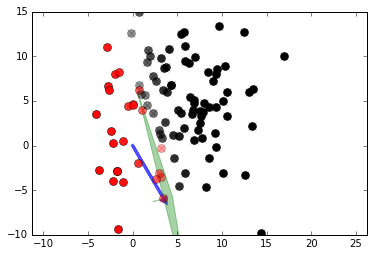

{'R2': 25.0, 'r2': 25.0, 'wgts': array([ 0.67709556,  0.11101873]), 'mean': array([ 3.34902427, -6.18606435])}
vanilla loss:  -18.14273475
loss: -4.87352144649


In [33]:
for t in range(100):
    params,Y = do_one_autograd_step(params,X,Targ,rate)
show_result()
print(params)
print('vanilla loss: ', np.sum(Targ*np.log(Y) + (1-Targ)*np.log(1-Y)))
print("loss:", training_loss(params))

## Mixture of Gaussians knob?

My model above used the loss function
$$ \mathcal{L} = \sum_n \rho_{n} \;\, \log P(\mathbf{x}_n \; \text{classified correctly}) $$
where $\rho_n$ is the "membership". I set $\rho_n = \exp(-d^2_n/2)$
where  $d_{n}$ is the Mahalanobis distance of the n-th input $\mathbf{x}_n$ under the current Gaussian.

Suppose this actually works and we have a bunch of such "boundary hunters".

They're each capable of independently doing something sensible, unlike vanilla perceptrons. But we do want them to interact just enough to stay out of each others' way. This makes me wonder whether using MoG to initialise them might be a good idea, and THAT makes me wonder whether we can just interpolate smoothly between these two loss functions. ie. is there a "knob" we can turn, which when set at one extreme gives the MoG and at the other gives a set of class boundaries? It would probably be a cute thing to be able to do, basically.

### MoG Loss function
The loss of a MoG model is a sum over training items, which are indexed by $n$.

For simplicity, let's suppose the $K$ mixture components all have the same prior $\pi_k = 1/K$, and same "volume" (determinant of the inverse of the covariance matrix, or somesuch). 

Then the probability density $\rho_{nk} = P(\mathbf{x}_n | k) \propto \exp(-d_{nk}^2 / 2)$. 

We can denote a "responsibility" (posterior probability) of the k-th Gaussian for the n-th input pattern 
$$ r_{nk} = \frac{\rho_{nk}}{\displaystyle{ \sum_{k^\prime} \rho_{nk^\prime}}}$$.


Per item, the loss of a MoG model is then
$$ \mathcal{L}_\text{MoG} = \sum_k r_{nk} \;\, \log P(\mathbf{x}_n \; \text{generated} | k) $$


I suspect a plausible loss function to use for the "hoarde of boundary hunters" could be (per item) as follows, which is very very super similar:
$$ \mathcal{L}_\text{HoBH} = \sum_k r_{nk} \;\, \log P(\mathbf{x}_n \; \text{classified correctly} | k) $$

If so, that's quite groovy as a generative model: the universe has to (a) place the point correctly, and (b) give it the right class to nail the whole problem.
ie. we could have a combined model with just uses the sum of the two losses, say, to model both the density and the class information.